In [3]:
using Plots, Random, Distributions, StatsBase, Printf, LaTeXStrings, 
    DataFrames, StatsPlots, KernelDensity
default(fillcolor=:lightgrey, markercolor=:black, markersize=2,
    grid=false, legend=false)

# The Gibss Sampler

The goal is to sample from a multivariate distribution, by repeatedly sampling from the full conditionals. Sampling from the conditional distributions yields a Markov chain: the newly proposed values depend on the present values, but not any of the past values. 

**Algorithm:**
Starting with $(X_1^{(0)}, X_2^{(0)}, \ldots, X_p^{(0)})$, iterate for $t = 1, 2, \ldots$:

$\quad 1.$ Draw $X_1^{(t)} \sim f_{X_1 | X_{-1}} (X_2^{(t-1)}, X_3^{(t-1)}, \ldots, X_p^{(t-1)})$

$\quad 2.$ Draw $X_2^{(t)} \sim f_{X_2 | X_{-2}} (X_1^{(t)}, X_3^{(t-1)}, \ldots, X_p^{(t-1)})$

$\quad \ldots$

$\quad p.$ Draw $X_p^{(t)} \sim f_{X_p | X_{-p}} (X_1^{(t)}, X_2^{(t)}, \ldots, X_{p-1}^{(t-1)})$

## Gibbs Sampler for a bivarite normal distribution

Goal: Estimate $\mathbb{P}(X_1 \geq 0, X_2 \geq 0)$ for a $N(\mu, \Sigma)$, where
    $$ \mu = \left(\begin{matrix} \mu_1 \\ \mu_2\end{matrix}\right)  \quad \Sigma = \left(\begin{matrix} \sigma_1^2 & \sigma_{12} \\ \sigma_{12} & \sigma_2^2 \end{matrix}\right)$$

Marginals:
1. $f(X_1 | X_2) \sim N\left(\mu_1 + \frac{\sigma_{12}}{\sigma_2^2(x_2 - \mu_2)}, \ \sigma_1^2 - \frac{\sigma_{12}^2}{\sigma_2^2}\right)$
1. $f(X_2 | X_1) \sim N\left(\mu_2 + \frac{\sigma_{12}}{\sigma_1^2(x_1 - \mu_1)}, \ \sigma_2^2 - \frac{\sigma_{12}^2}{\sigma_1^2}\right)$

In [1]:
function gibbs_sample(μ, Σ, N=1000)
    σ_12 = Σ[1, 2]
    σ_1 = Σ[1, 1]
    σ_2 = Σ[2, 2]
    X = reshape(zeros(N*2), N, 2)
    X[1,:] = μ
    d = Normal()
    for t in range(2, N)
        X[t, 1] = rand(d) * sqrt(σ_1 - (σ_1/σ_2)^2) + μ[1] + σ_12/σ_2*(X[t-1, 2] - μ[2])
        X[t, 2] = rand(d) * sqrt(σ_2 - (σ_12/σ_2)^2) + μ[2] + σ_12/σ_1*(X[t, 1] - μ[1])
    end
    X
end

gibbs_sample (generic function with 2 methods)

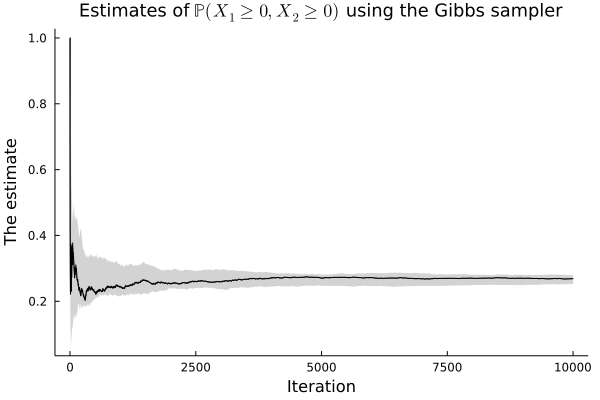

In [12]:
n = 10000
σ = 0.3
Σ = [[1 σ ]; [σ 1]]
μ = [0 0]

X = gibbs_sample(μ, Σ, n)

P_min = P_max = P = cumsum(X[:, 1] .>= 0 .&& X[:, 2] .>= 0) ./ [1:1:n;]

for i in range(1, 100)
    X = gibbs_sample(μ, Σ, n)
    P = cumsum(X[:, 1] .>= 0 .&& X[:, 2] .>= 0) ./ [1:1:n;]
    P_min = min.(P, P_min)
    P_max = max.(P, P_max)
end

plot(
    [P P], fillrange=[P_min, P_max], color="black",
    xlab="Iteration",
    ylab="The estimate",
    title = "Estimates of " * L"\mathbb{P}(X_1 \geq 0, X_2 \geq 0)" * 
    " using the Gibbs sampler",
    titlefontsize = 12
)

### Sampling from a bivariate normal with a low vs. a high correlation

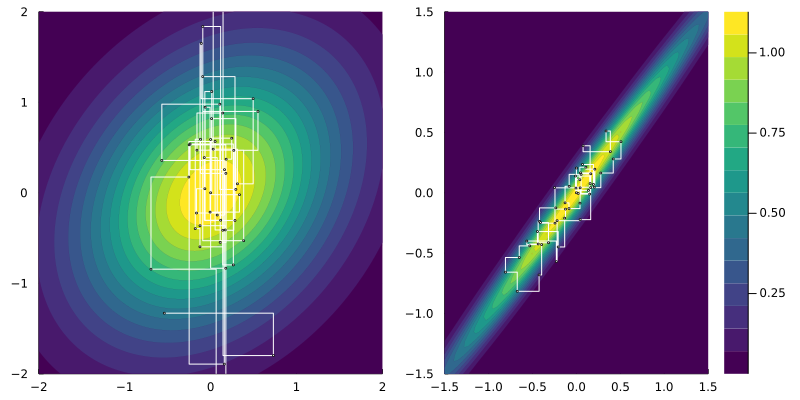

In [13]:
n = 50
Σ_l = [1 0.3; 0.3 1]
Σ_h = [1 0.99; 0.99 1]
μ = [0, 0]

# Get the samples
Xl = gibbs_sample(μ, Σ_l, n)
Xh = gibbs_sample(μ, Σ_h, n)

# Get the Normal densities
dl = MvNormal(μ, Σ_l)
dh = MvNormal(μ, Σ_h)
X = range(-2, 2, length=100)
Y = range(-2, 2, length=100)
Zl = [pdf(dl, [x,y]) for y in Y, x in X]
Zh = [pdf(dh, [x,y]) for y in Y, x in X]

# Make the plots
default()
contourf(X, Y, Zl, color=:viridis, width=0.01, layout=(1,2), subplot=1,
     ylim=(-2, 2), xlim=(-2, 2), size = (800, 400), legend=false)
plot!(Xl[:,1], Xl[:, 2], linetype=:steppre, subplot=1, color="white")
scatter!(Xl[:,1], Xl[:, 2], subplot=1, markersize=2, color="white")

contourf!(X, Y, Zh, color=:viridis, width=0.01, subplot=2, legend=false,
    ylim=(-1.5, 1.5), xlim=(-1.5, 1.5))
plot!(Xh[:,1], Xh[:, 2], linetype=:steppre, subplot=2, 
    ylim=(-1.5, 1.5), xlim=(-1.5, 1.5), color="white")
scatter!(Xh[:,1], Xh[:, 2], subplot=2, markersize=2, color="white")

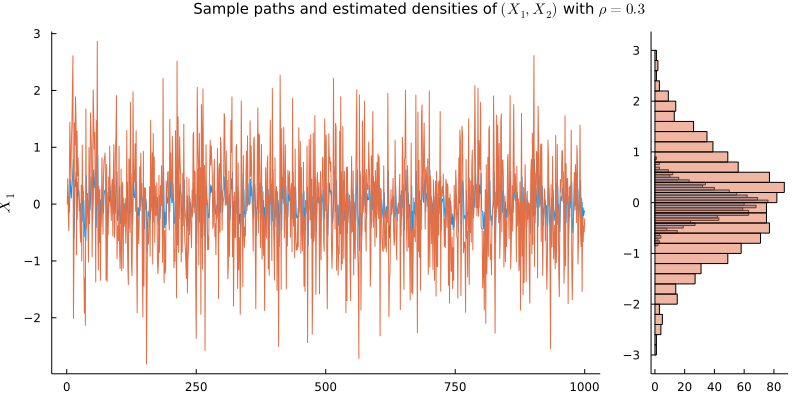

In [20]:
n = 1000
# sample
Xl = gibbs_sample(μ, Σ_l, n)
Xh = gibbs_sample(μ, Σ_h, n)

#plot the low-correlated sample
layout = @layout [a{0.1h} ;
                  c d{0.2w}]
default(legend=false, grid=false)
plot(
    title="Sample paths and estimated densities of " *
    "\$(X_1, X_2)\$ with \$\\rho=0.3\$", 
    titlefontsize=10, layout=layout, subplot=1, framestyle=:nothing, 
    showaxis=false, xticks=false, yticks=false, bottom_margin = -50Plots.px,
    size = (800, 400)
)
plot!(Xl, subplot=2, ylab=L"X_1")
histogram!(Xl[:,1], subplot=3, orientation=:h, bins=40, fillcolor=1, fillalpha=0.5)
histogram!(Xl[:,2], subplot=3, orientation=:h, bins=40, fillcolor=2, fillalpha=0.5)

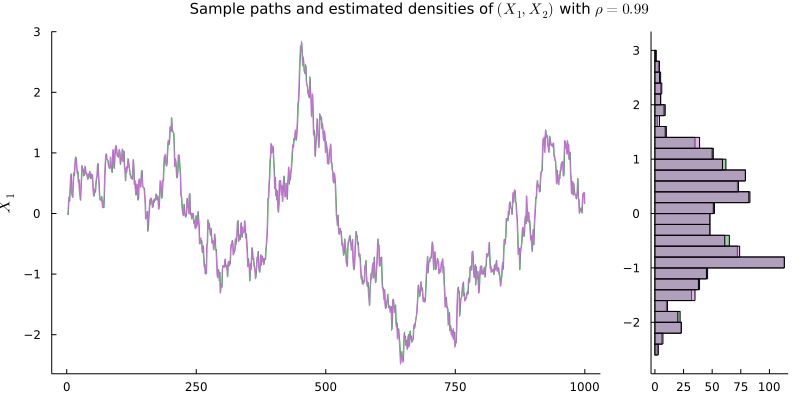

In [21]:
#plot high-correlated sample
layout = @layout [a{0.1h} ;
                  c d{0.2w}]
plot(
    title="Sample paths and estimated densities of " *
    "\$(X_1, X_2)\$ with \$\\rho=0.99\$", 
    titlefontsize=10, layout=layout, subplot=1, framestyle=:nothing, 
    showaxis=false, xticks=false, yticks=false, bottom_margin = -50Plots.px,
    size = (800, 400)
)
plot!(Xh, subplot=2, ylab=L"X_1", color=[3 4])
histogram!(Xh[:,1], subplot=3, orientation=:h, bins=40, fillcolor=3, fillalpha=0.5)
histogram!(Xh[:,2], subplot=3, orientation=:h, bins=40, fillcolor=4, fillalpha=0.5)

**Conclusions:**
For the highly correlated distribution, it is harder for the Markov chain to explore the whole support. The produced samples are highly correlated. The Chain is said to be *slowly mixing*.

## The Poisson change point model

**Model**:


Assume the following of two regimes for $n$ random variables $Y_1, \ldots , Y_n$.
$$\begin{aligned}
Y_i &\sim Poi(\lambda_1) & i &= 1, \ldots, M \\
Y_i &\sim Poi(\lambda_2) & i &= M+1, \ldots, 
\end{aligned}
$$

**Priors**:
$$
\begin{aligned}
\lambda_i &\sim Gamma(\alpha_i, \beta_i) \\
M &\sim Uniform\{1, \ldots, n-1\}
\end{aligned}
$$

**Marginals**:
$$
\begin{aligned}
f(\lambda_1 | \mathbf{Y}, M) &\sim Gamma(\alpha_1 = \sum_{i=1}^M{y_i}, \beta_1 + M) \\
f(\lambda_2 | \mathbf{Y}, M) &\sim Gamma(\alpha_2 = \sum_{i=M+1}^n{y_i}, \beta_2 + n - M) \\
f(M | \mathbf{Y}, \lambda_1, \lambda_2) &\propto \lambda_1^{\sum_{i=1}^M{y_i}}\lambda_2^{\sum_{i=M+1}^n{y_i}}\exp((\lambda_2 - \lambda_1)M)
\end{aligned}
$$

Using the Gibbs sampler, we can find the estimates of the posterior distribution of the parameters $\lambda_1$, $\lambda_2$, and $M$, under the observations $y_1, \ldots y_n$.
To showcase the application of the Poisson model we first apply it to the simulated data, and later to a real data set - British coal mine disaster data [1].

In [28]:
function sample_M(Y, λ_1, λ_2)
    n = length(Y)
    log_p = (cumsum(Y[1:(n-1)]) .* log(λ_1)) + 
            ((sum(Y) .- cumsum(Y[1:(n-1)])) .* log(λ_2)) +
             (λ_2 - λ_1) .* [1:1:(n-1);]
    p = exp.(log_p)
    p = p ./ sum(p)
    StatsBase.sample([1:1:(n-1);], Weights(p), 1)
end

function gibbs_sample(;Y, α_1, β_1, α_2, β_2, M_0, N=1000)
    n = length(Y)
    M = Array{Int64, 1}(undef, N)
    λ_1 = Array{Float64, 1}(undef, N)
    λ_2 = Array{Float64, 1}(undef, N)
    M[1] = M_0
    λ_1[1] = (α_1 - 1) / β_1
    λ_2[1] = (α_2 - 1) / β_2
    for t in range(2, N)
        λ_1[t] = rand(Gamma(α_1 + sum(Y[1:M[t - 1]]), 
                1 / (β_1 + M[t - 1])))
        λ_2[t] = rand(Gamma(α_2 + sum(Y[(M[t - 1] + 1):end]), 
                1 / (β_2 + n - M[t - 1])))
        M[t] = sample_M(Y, λ_1[t], λ_2[t])[1]
    end
    DataFrame(λ_1=λ_1, λ_2=λ_2, M=M)
end

gibbs_sample (generic function with 3 methods)

### Simulated data

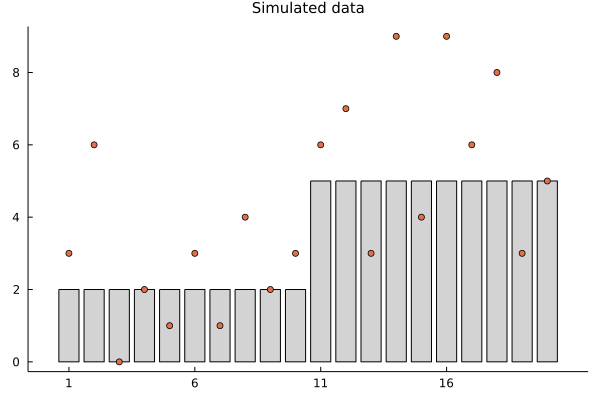

In [29]:
Random.seed!(0)
λ_1 = 2
λ_2 = 5
M_1 = 10
M_2 = 10
n = M_1 + M_2
d1 = Poisson(λ_1)
d2 = Poisson(λ_2)

Y_1 = rand(d1, M_1)
Y2 = rand(d2, M_2)
Y = vcat(Y_1, Y2)

default(fillcolor="lightgrey", titlefontsize=10)
bar(vcat(fill(λ_1, M_1), fill(λ_2, M_2)), xticks=[1:5:n;],
    title="Simulated data")
scatter!([1:1:n;], Y)

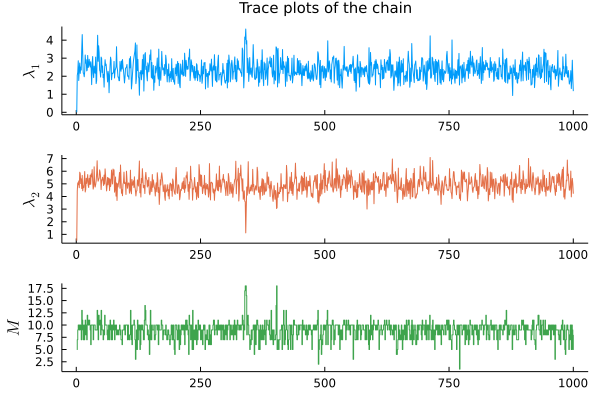

In [30]:
α_1 = 1
β_1 = 1
α_2 = 2
β_2 = 2
M_0 = 5

chain1 = gibbs_sample(Y=Y, α_1=α_1, β_1=β_1, 
    α_2=α_2, β_2=β_2, M_0=M_0)

# trace plots
plot(chain1[!, "λ_1"], subplot=1, layout=(3,1), ylab = L"\lambda_1",
    title="Trace plots of the chain", color=1)
plot!(chain1[!, "λ_2"], subplot=2, ylab = L"\lambda_2", color=2)
plot!(chain1[!, "M"], subplot=3, linetype=:steppost, ylab = L"M", color=3)

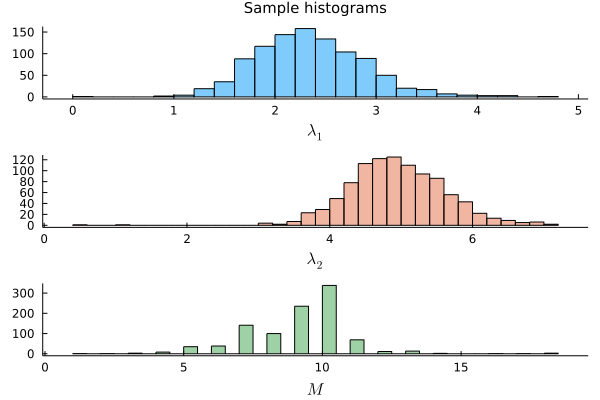

In [32]:
# histograms of the samples
default(fillalpha=0.5)
histogram(chain1[!, "λ_1"], subplot=1, layout=(3,1), xlab = L"\lambda_1",
    title="Sample histograms", fillcolor=1)
histogram!(chain1[!, "λ_2"], subplot=2, xlab = L"\lambda_2", fillcolor=2)
histogram!(chain1[!, "M"], subplot=3, xlab = L"M", fillcolor=3)

### Real data

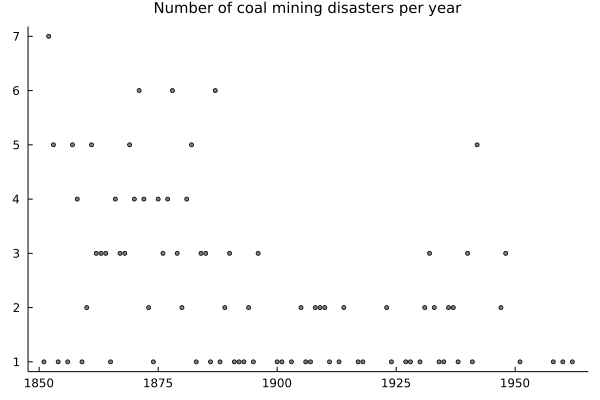

In [33]:
using RDatasets

coal = dataset("boot","coal")
coal[!, "year"] = Int.(round.(coal[!, "Date"]))

gd = groupby(coal, :year)
df = combine(gd, nrow => :count)
@df df scatter(:year, :count, markersize=3, markercolor="grey",
    title="Number of coal mining disasters per year")

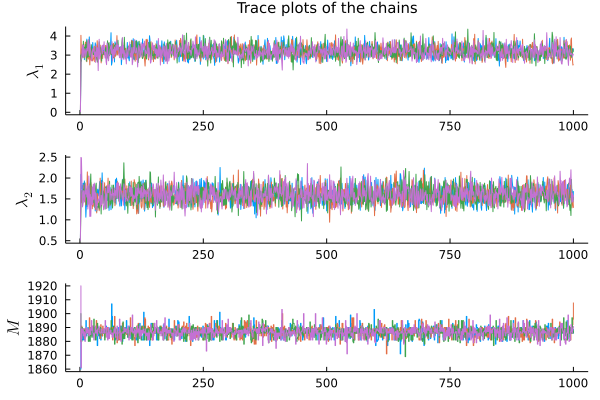

In [34]:
α_1 = 1
β_1 = 1
α_2 = 2
β_2 = 2

chain1 = gibbs_sample(Y=df[!, "count"], α_1=α_1, β_1=β_1, 
    α_2=α_2, β_2=β_2, M_0=10)
chain2 = gibbs_sample(Y=df[!, "count"], α_1=α_1, β_1=β_1, 
    α_2=α_2, β_2=β_2, M_0=30)
chain3 = gibbs_sample(Y=df[!, "count"], α_1=α_1, β_1=β_1, 
    α_2=α_2, β_2=β_2, M_0=50)
chain4 = gibbs_sample(Y=df[!, "count"], α_1=α_1, β_1=β_1, 
    α_2=α_2, β_2=β_2, M_0=70)

# trace plots
plot([chain1[!, "λ_1"] chain2[!, "λ_1"] chain3[!, "λ_1"] chain4[!, "λ_1"]], 
    subplot=1, layout=(3,1), ylab = L"\lambda_1",
    title="Trace plots of the chains")
plot!([chain1[!, "λ_2"] chain2[!, "λ_2"] chain3[!, "λ_2"] chain4[!, "λ_2"]],
    subplot=2, ylab = L"\lambda_2")
plot!(1850 .+ [chain1[!, "M"] chain2[!, "M"] chain3[!, "M"] chain4[!, "M"]]
    , subplot=3, linetype=:steppost, ylab = L"M")

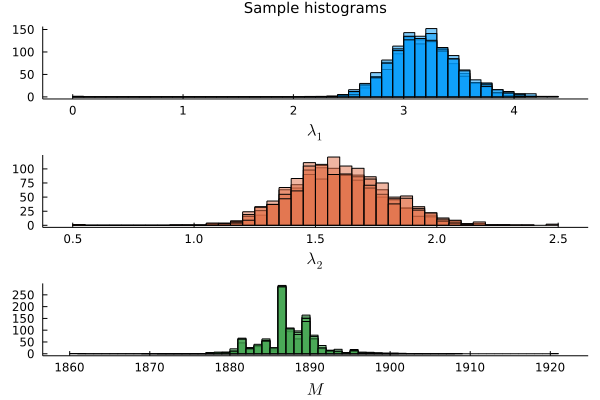

In [36]:
# histograms of the samples
default(fillalpha=0.5)
histogram([chain1[!, "λ_1"] chain2[!, "λ_1"] chain3[!, "λ_1"] chain4[!, "λ_1"]],
    subplot=1, layout=(3,1), xlab = L"\lambda_1",
    title="Sample histograms", fillcolor=1)
histogram!([chain1[!, "λ_2"] chain2[!, "λ_2"] chain3[!, "λ_2"] chain4[!, "λ_2"]], 
    subplot=2, xlab = L"\lambda_2", fillcolor=2)
histogram!(1850 .+ [chain1[!, "M"] chain2[!, "M"] chain3[!, "M"] chain4[!, "M"]],
    subplot=3, xlab = L"M", fillcolor=3)

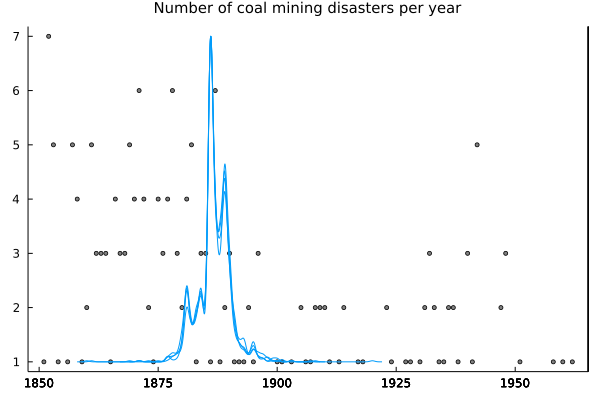

In [37]:
p = scatter(df[!,"year"], df[!,"count"], markersize=3, markercolor="grey",
    title="Number of coal mining disasters per year")
for c in [chain1, chain2, chain3, chain4]
    plot!(twinx(p), kde(1850 .+ c[!, "M"]), yticks = [1:250:50;])
end
p

---
Bibliography:
1. ST407 Monte Carlo Methods - Lecture notes by Adam M. Johansen (University of Warwick)

References:
1. British Coal Mine Disasters -  A Handbook of Small Data Sets, Chapman and Hall.